# Machine Learning with Spark

In this notebook we will perform basic data processing with pySpark and we will demonstrate some of the classification algorithms on the Spark Machine Learning Library, MLlib, namely:
1. Naive Bayes
2. Decision tree
3. Random forest
4. Gradient Boosted Trees

As an example we use the [publicly available data](https://www.kaggle.com/c/otto-group-product-classification-challenge/data) of products of the online-shop Otto. The data contains more than 60k products with 93 numerical features and their classification in 9 product categories.

In [1]:
# To use pyspark in the notebook we first import findspark:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline

**Loading** the data:

In [3]:
# we create a Resilient Distributed Dataset (RDD) from a csv file:
product_data_raw = sc.textFile("train_noheader.csv")
product_data_raw.first()

u'1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,4,1,1,0,0,2,0,0,0,0,0,1,0,0,0,0,1,0,5,0,0,0,0,0,2,0,0,0,0,0,1,0,0,2,0,0,11,0,1,1,0,1,0,7,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,Class_1'

In [4]:
product_data = product_data_raw.map(lambda line: line.split(','))
print product_data.first()

[u'1', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'2', u'0', u'0', u'0', u'0', u'1', u'0', u'4', u'1', u'1', u'0', u'0', u'2', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'1', u'0', u'5', u'0', u'0', u'0', u'0', u'0', u'2', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'2', u'0', u'0', u'11', u'0', u'1', u'1', u'0', u'1', u'0', u'7', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'2', u'1', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'Class_1']


**Exploring** the different classes:

In [5]:
# here there are some examples of functions that we can apply to RDDs: map, distinct, count, countByValue... 
classes = product_data.map(lambda fields: fields[-1])
print("There are %i different classes. These are:" % classes.distinct().count())
print sorted(classes.distinct().collect())

There are 9 different classes. These are:
[u'Class_1', u'Class_2', u'Class_3', u'Class_4', u'Class_5', u'Class_6', u'Class_7', u'Class_8', u'Class_9']


In [6]:
print "Counts by each class:"
counts_by_class = sorted(classes.countByValue().items())
counts_by_class 

Counts by each class:


[(u'Class_1', 1929),
 (u'Class_2', 16122),
 (u'Class_3', 8004),
 (u'Class_4', 2691),
 (u'Class_5', 2739),
 (u'Class_6', 14135),
 (u'Class_7', 2839),
 (u'Class_8', 8464),
 (u'Class_9', 4955)]

**Plotting** the counts per class:

In [7]:
# preparing the arrays for matplotlib
x_axis = np.array([tup[0] for tup in counts_by_class])
y_axis = np.array([tup[1] for tup in counts_by_class])

In [8]:
# alternative plot with seaborn
#sns.barplot(x=np.arange(1,10), y=y_axis)

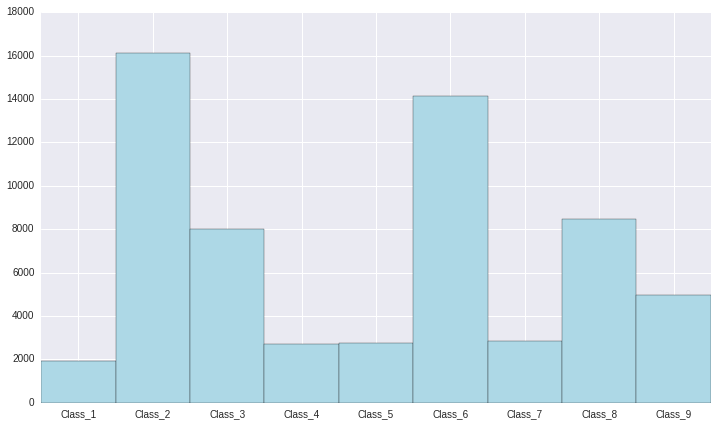

In [9]:
pos = np.arange(len(x_axis))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis, width = width, color='lightblue')
fig = plt.gcf()
fig.set_size_inches(12, 7)

Exploring the data with **Pandas**:

In [10]:
df=pd.read_csv("train.csv", index_col='id')
df.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
4,1,0,0,1,6,1,5,0,0,1,...,0,1,2,0,0,0,0,0,0,Class_1
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [11]:
# summary of statistics with the describe function:
df.describe()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,...,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,0.263906,...,0.070752,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135
std,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,1.083340,...,1.151460,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61.00000,51.000000,64.000000,70.000000,19.000000,10.000000,38.000000,76.000000,43.000000,30.000000,...,76.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.000000,52.000000,19.000000,87.000000


In [12]:
# percentage of null data in the dataset,
# and uniques (here not relevant because the features are numerical, not categorical):
print("column        %null    n.uniques")
for col in df.columns:
    print("{:15s} {:.1f}%    {:d}".format(col, float(df[col].isnull().sum()) / df.shape[0] * 100,
                                               len(df[col].unique())))

column        %null    n.uniques
feat_1          0.0%    42
feat_2          0.0%    37
feat_3          0.0%    48
feat_4          0.0%    59
feat_5          0.0%    15
feat_6          0.0%    9
feat_7          0.0%    30
feat_8          0.0%    55
feat_9          0.0%    40
feat_10         0.0%    26
feat_11         0.0%    28
feat_12         0.0%    20
feat_13         0.0%    51
feat_14         0.0%    32
feat_15         0.0%    37
feat_16         0.0%    28
feat_17         0.0%    40
feat_18         0.0%    30
feat_19         0.0%    105
feat_20         0.0%    27
feat_21         0.0%    15
feat_22         0.0%    21
feat_23         0.0%    24
feat_24         0.0%    66
feat_25         0.0%    28
feat_26         0.0%    31
feat_27         0.0%    55
feat_28         0.0%    21
feat_29         0.0%    50
feat_30         0.0%    51
feat_31         0.0%    29
feat_32         0.0%    40
feat_33         0.0%    20
feat_34         0.0%    49
feat_35         0.0%    78
feat_36         0.0%  

**Plotting** box plots for each feature

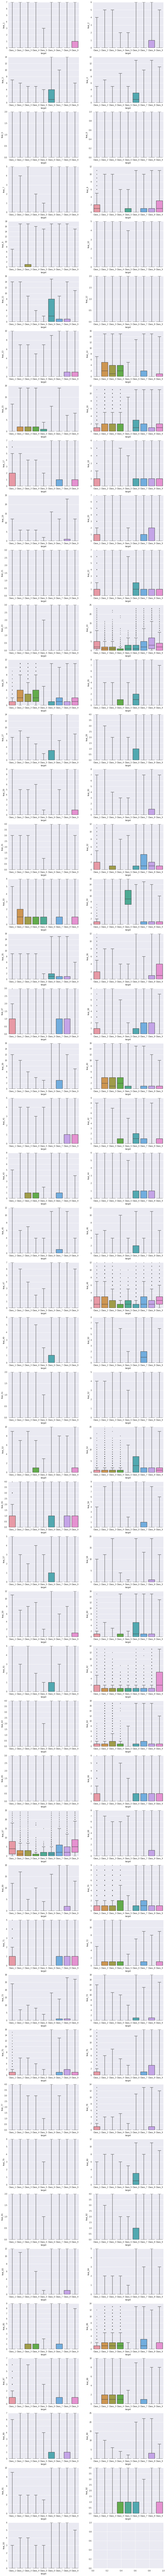

In [13]:
numfeats2plot = 93
numrows = numfeats2plot/2 if numfeats2plot % 2 == 0 else (numfeats2plot/2 + 1)
f, axes = plt.subplots(numrows, 2, figsize=(14, numfeats2plot*2.5)) # , sharex=True)
for i,feat in enumerate(df.columns[:numfeats2plot]):
    mask = (df[feat] < df[feat].std()*5)
    sns.boxplot(df[mask][feat], df.target, ax=axes[int(i/2), int(round((i/2.-int(i/2))))])

## **Classification** algortihms in the Spark ML library:

**Please note** that we only attempt to show how to use these mllib algorithms, so you will not find here any parameter tunning, cross-validation or corrections for overfitting or bias.

In [14]:
import pyspark.mllib.regression as mllib_reg
import pyspark.mllib.linalg as mllib_lalg
import pyspark.mllib.classification as mllib_class
import pyspark.mllib.tree as mllib_tree

In [15]:
# the labels (the classes in this case) must be first converted to integers:
def convert_classes_to_int(line):
    line[-1] = int(line[-1][-1])-1
    return line
product_data = product_data.map(lambda x: convert_classes_to_int(x))
print product_data.first()

[u'1', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'2', u'0', u'0', u'0', u'0', u'1', u'0', u'4', u'1', u'1', u'0', u'0', u'2', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'1', u'0', u'5', u'0', u'0', u'0', u'0', u'0', u'2', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'2', u'0', u'0', u'11', u'0', u'1', u'1', u'0', u'1', u'0', u'7', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'2', u'1', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', 0]


In [17]:
# we label the RDD using the LabeledPoint function, which arguments are the labels and the features
# note that the features are converted to the "dense vectors" mllib class
product_data_labeled = product_data.map(lambda fields: mllib_reg.LabeledPoint(fields[-1], mllib_lalg.Vectors.dense(fields[:-1])))

In [18]:
# Shuffle and split data into training (70%) and test (30%)
train, test = product_data_labeled.randomSplit([0.7, 0.3], seed = 13)

In [19]:
#sorted(train.map(lambda x: x[1]).countByValue().items())

#### Naive Bayes classifier:

In [20]:
## http://spark.apache.org/docs/latest/mllib-naive-bayes.html
# parameters:
lamda = 1.0

# initialize classifier:
nbay = mllib_class.NaiveBayes.train(train, lamda)

# Make prediction and test accuracy.
predictionAndLabel = test.map(lambda p : (nbay.predict(p.features), p.label))
testErr = predictionAndLabel.filter(lambda (v, p): v != p).count() / float(test.count())
accuracy = 100.0 * predictionAndLabel.filter(lambda (x, v): x == v).count() / test.count()

print('lamda=%.2f, Accuracy=%.2f%%' % (lamda, accuracy))

# Save model:
#nbay.save(sc, "nbay-l%.2f" % lamda)
# load model:
#sameModel = mllib_class.NaiveBayesModel.load(sc, "myModelPath")

lamda=1.00, Accuracy=68.68%


#### Decision tree classifier:

In [25]:
## http://spark.apache.org/docs/latest/mllib-decision-tree.html
# parameters:
max_depth_tree = 3
maxBins= 16 # discretization of continuous features (max. is 32)

# initialize classifier:
tree = mllib_tree.DecisionTree.trainClassifier(train, numClasses=classes.distinct().count(),
                                               categoricalFeaturesInfo={}, #  Empty categoricalFeaturesInfo indicates all features are continuous
                                               impurity='gini', maxDepth=max_depth_tree, maxBins=maxBins)
# Evaluate model on test instances and compute test error
predictions = tree.predict(test.map(lambda x: x.features))
labelsAndPredictions = test.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(test.count())
accuracy = 100. * labelsAndPredictions.filter(lambda (x, v): x == v).count() / test.count()
print('maxDepth=%i, maxBins=%i, Accuracy = %.2f%%' % (max_depth_tree, maxBins, accuracy))
#print('Learned classification tree model:')
#print(tree.toDebugString())

# Save model
#tree.save(sc, "tree-d%i-b%i" % (max_depth_tree, maxBins))
# to load it:
#sametreeModel = mllib_tree.DecisionTreeModel.load(sc, "myModelPath")

maxDepth=3, maxBins=16, Accuracy = 81.00%


#### Random forest classifier:

In [26]:
# parameters:
numTrees = 40
max_depth_tree = 6
maxBins= 32

# initialize classifier:
randfor = mllib_tree.RandomForest.trainClassifier(train, numClasses=classes.distinct().count(), categoricalFeaturesInfo={},
                                                  numTrees=numTrees, featureSubsetStrategy="auto",
                                                  impurity='gini', maxDepth=max_depth_tree, maxBins=maxBins)

# Evaluate model on test instances and compute test error
predictions = randfor.predict(test.map(lambda x: x.features))
labelsAndPredictions = test.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(test.count())
accuracy = 100. * labelsAndPredictions.filter(lambda (x, v): x == v).count() / test.count()
print('maxDepth=%i, maxBins=%i, Accuracy = %.2f%%' % (max_depth_tree, maxBins, accuracy))
#print('Learned classification tree model:')
#print(randfor.toDebugString())

# Save model
#randfor.save(sc, "randfor-d%i-b%i" % (max_depth_tree, maxBins))
# to load it:
#sameModel = mllib_tree.RandomForestModel.load(sc, "myModelPath")

maxDepth=6, maxBins=32, Accuracy = 64.33%


#### Gradient Boosted Trees:

In [36]:
# http://spark.apache.org/docs/latest/mllib-ensembles.html
# it has a "Validation while training" functionality that allows to automatically choose 
# the num of iterations that give the best result
# parameters:
n_iter = 80
numTrees = 20
max_depth_tree = 4

# initialize classifier:
#mllib_tree.configuration.BoostingStrategy.defaultParams("Classification")
gbt = mllib_tree.GradientBoostedTrees.trainClassifier(train, categoricalFeaturesInfo={}, loss="logLoss",
                                                      numIterations=n_iter)

# Evaluate model on test instances and compute test error
predictions = gbt.predict(test.map(lambda x: x.features))
labelsAndPredictions = test.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(test.count())
accuracy = 100. * labelsAndPredictions.filter(lambda (x, v): x == v).count() / test.count()
print('numIterations%i, Accuracy = %.2f%%' % (n_iter, accuracy))
#print('Learned classification tree model:')
#print(gbt.toDebugString())

# Save model
#gbt.save(sc, "gbt-i%i" % (n_iter))
# to load it:
#sameModel = mllib_tree.GradientBoostedTreesModel.load(sc, "myModelPath")

numIterations80, Accuracy = 28.91%
